In [12]:
import pandas as pd
import pickle
import sqlite3
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

In [13]:
#loading db
sqlite_db_path = "../student_performance.db"
conn = sqlite3.connect(sqlite_db_path)


query_mat = "SELECT * FROM student_mat"
df_mat = pd.read_sql(query_mat, conn)

query_por = "SELECT * FROM student_por"
df_por = pd.read_sql(query_por, conn)

In [14]:
# combining the two in the db
df = pd.concat([df_mat, df_por], ignore_index=True)

In [15]:
# closing connection
conn.close()


In [16]:
print("Loaded Data Preview (Merged Student Data):")
display(df.head())

df = df.dropna(subset=['G3'])

Loaded Data Preview (Merged Student Data):


,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


In [17]:
# encoding categorical features (since sqlite doesn't play nice)
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

In [18]:
# Normalizing numerical features for future reference (further optimization)

scaler = StandardScaler()
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
grade_cols = ['G1', 'G2', 'G3']
numeric_cols = [col for col in df.select_dtypes(include=['int64', 'float64']).columns if col not in grade_cols]
df[numeric_cols] = scaler.fit_transform(df[numeric_cols])

In [19]:
# Compute correlation matrix using Spearman (handles ordinal data better)
correlation_matrix = df.corr(method='spearman')


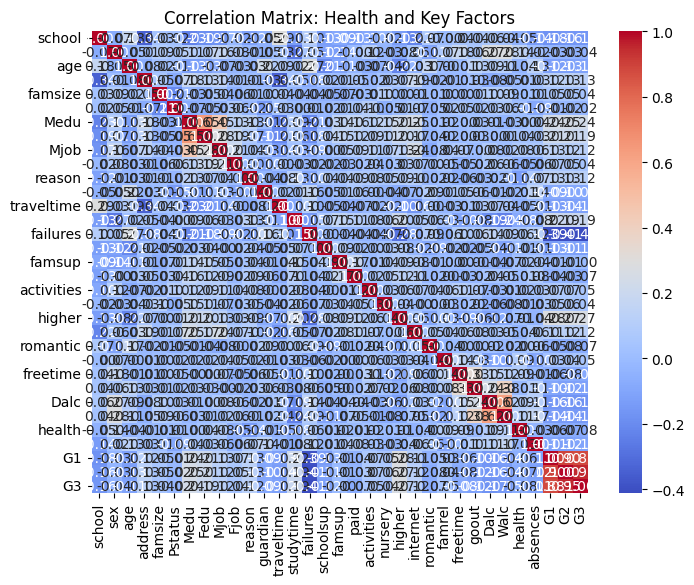

In [20]:
# Visualize correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix: Health and Key Factors")
plt.show()

In [21]:
# Compute Spearman correlations individually
health_abs_corr, p_abs = spearmanr(df['health'], df['absences'])
health_grade_corr, p_grade = spearmanr(df['health'], df['G3'])
health_famrel_corr, p_famrel = spearmanr(df['health'], df['famrel'])

In [22]:
# Display results
correlation_results = pd.DataFrame({
    "Variable": ["Health vs Absences", "Health vs Final Grade (G3)", "Health vs Family Relationships"],
    "Spearman Correlation": [health_abs_corr, health_grade_corr, health_famrel_corr],
    "P-value": [p_abs, p_grade, p_famrel]
})

In [23]:
# Print correlation results
print(correlation_results)

                         Variable  Spearman Correlation   P-value
0              Health vs Absences             -0.034380  0.267071
1      Health vs Final Grade (G3)             -0.080785  0.009017
2  Health vs Family Relationships              0.089701  0.003723


In [24]:
# Feature Engineering (first 3 metrics for what makes them at risk)
df['health_impact_score'] = (df['health'] * (df['G1'] + df['G2'] + df['G3'])) / (df['absences'] + 1)
df['health_absence_risk'] = ((df['health'] < 3) & (df['absences'] > df['absences'].quantile(0.75))).astype(int)
df['family_support'] = (df['famrel'] * (df['G1'] + df['G2'] + df['G3'])) / (df['absences'] + 1)

# Had to create multi-class labels to fit the linear model (this seamed better than binary good/bad)
def categorize_g3(grade):
    if grade < 10:
        return 0  # Low
    elif 10 <= grade < 15:
        return 1  # Medium
    else:
        return 2  # High

df['G3_category'] = df['G3'].apply(categorize_g3)

# Defining features and target variable
X = df.drop(columns=['G3', 'G3_category'])
y = df['G3_category']

# Spliting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [25]:
# Load Logistic Regression model
with open('../Resources/logistic_regression_model.pkl', 'rb') as file:
    model = pickle.load(file)

model = LogisticRegression()
model.fit(X_train, y_train)

predictions = model.predict(X_test)

print(predictions)

[0 1 1 1 1 1 1 2 2 2 1 2 2 1 0 1 1 0 1 1 0 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1 0
 0 1 1 2 1 2 1 2 0 1 1 0 1 1 1 1 0 0 2 1 2 1 0 1 1 0 2 1 1 1 1 2 2 1 1 2 2
 0 2 1 1 1 1 1 2 1 1 0 1 0 1 1 1 2 0 1 1 1 1 1 0 2 1 1 1 1 1 1 1 2 1 1 0 1
 1 1 1 1 0 1 1 1 2 1 0 2 1 1 2 1 1 0 2 1 1 2 2 1 1 1 2 1 2 1 1 1 2 2 0 1 2
 1 2 2 0 1 1 1 1 1 1 0 1 1 1 2 1 1 2 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1
 2 1 1 1 1 1 1 0 0 1 1 0 1 1 0 2 2 0 1 0 1 0 0 0]


c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [26]:
# # Baseline logistic regression model
log_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
log_model.fit(X_train, y_train)
y_pred_log = log_model.predict(X_test)
log_accuracy = accuracy_score(y_test, y_pred_log)
print("Logistic Regression Model Evaluation:")
print("Accuracy:", log_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_log))
print(classification_report(y_test, y_pred_log))

Logistic Regression Model Evaluation:
Accuracy: 0.8516746411483254
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.80      0.80        46
           1       0.87      0.88      0.87       122
           2       0.85      0.83      0.84        41

    accuracy                           0.85       209
   macro avg       0.84      0.84      0.84       209
weighted avg       0.85      0.85      0.85       209

              precision    recall  f1-score   support

           0       0.80      0.80      0.80        46
           1       0.87      0.88      0.87       122
           2       0.85      0.83      0.84        41

    accuracy                           0.85       209
   macro avg       0.84      0.84      0.84       209
weighted avg       0.85      0.85      0.85       209



c:\Users\ntrie\anaconda3\envs\my_dev\lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [27]:
# baseline multi-class Decision Tree model
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
tree_accuracy = accuracy_score(y_test, y_pred_tree)
print("Decision Tree Model Evaluation:")
print("Accuracy:", tree_accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred_tree))
print(classification_report(y_test, y_pred_tree))

Decision Tree Model Evaluation:
Accuracy: 0.8229665071770335
Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.83      0.76        46
           1       0.86      0.84      0.85       122
           2       0.89      0.78      0.83        41

    accuracy                           0.82       209
   macro avg       0.82      0.81      0.81       209
weighted avg       0.83      0.82      0.82       209

              precision    recall  f1-score   support

           0       0.70      0.83      0.76        46
           1       0.86      0.84      0.85       122
           2       0.89      0.78      0.83        41

    accuracy                           0.82       209
   macro avg       0.82      0.81      0.81       209
weighted avg       0.83      0.82      0.82       209

